In [1]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import torch.nn as nn
import torch
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline

In [2]:
# input image
# LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
# IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

In [90]:
## Get original model; untrained
CLASSES = 14
def get_symbol(out_features=CLASSES):
    model = models.densenet.densenet121(pretrained=True)
    # Replace classifier (FC-1000) with (FC-14)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, out_features),
        nn.Sigmoid())
    # CUDA
    model.cuda()  
    return model

In [91]:
## Load the trained_model
azure_chest_xray_sym_test = get_symbol()
chkpt = torch.load("best_azure_chest_xray_model_v2.pth.tar")
azure_chest_xray_sym_test.load_state_dict(chkpt['state_dict'])

In [92]:
finalconv_name = 'features'

In [93]:
net = (azure_chest_xray_sym_test)
# net.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [94]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

In [95]:
net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [96]:
# get the softmax weight
params = list(net.parameters())
# params
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

In [97]:
weight_softmax 

array([[-1.3348794e-02, -6.4276294e-03, -1.0305768e-02, ...,
        -2.5093066e-02,  2.2662891e-02, -2.3525052e-02],
       [-2.5547225e-02,  7.0131393e-03, -8.1166252e-03, ...,
        -3.3769105e-03,  2.5628036e-02,  1.9579869e-02],
       [-2.5904220e-02, -8.6662015e-03, -2.3206254e-02, ...,
        -2.3802536e-02, -3.2277007e-02, -6.7511913e-03],
       ...,
       [-5.2231416e-04,  2.2125397e-02, -3.9432708e-02, ...,
        -1.8380815e-02, -2.2386393e-02, -4.2112626e-02],
       [-3.3154108e-02,  2.0174272e-02, -2.7417365e-04, ...,
        -2.3728751e-02,  6.4972279e-05,  1.6205108e-02],
       [-2.6959922e-02,  7.2249435e-03, -1.4124089e-02, ...,
         2.6411904e-02,  8.3969962e-03, -3.1637654e-02]], dtype=float32)

In [98]:
weight_softmax.shape

(14, 1024)

In [99]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [100]:
# IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

In [101]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3), ## needed to 
   transforms.ToTensor(),
   normalize
])

In [102]:
path = "images/"
train_img_list = pd.read_pickle(path + "train_val_filtered.pkl")
test_img_list = pd.read_pickle(path + "test_filtered.pkl")

In [449]:
# train_img_list.shape

In [450]:
# test_img_list.shape

In [105]:
label_df = pd.concat([train_img_list[['img_filename', 'text_label']], 
           test_img_list[['img_filename', 'text_label']]])

In [106]:
label_df.head()

,img_filename,text_label
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000004_000.png,Mass|Nodule


In [107]:
label_dict = dict(zip(label_df.img_filename, label_df.text_label))

In [108]:
image_list = glob.glob('images/*.png')
len(image_list)

30000

#### Read a random image and predict 

In [618]:
image = np.random.randint(0, high = len(image_list))
image_list[image]

'images/00011402_019.png'

In [619]:
label = label_dict[image_list[image].split("/")[1]]
label

'Atelectasis'

In [620]:
# response = requests.get(IMG_URL)
img_pil = Image.open(image_list[image])
img_pil.thumbnail((224,224),Image.ANTIALIAS)
img_pil.save('test.jpg')

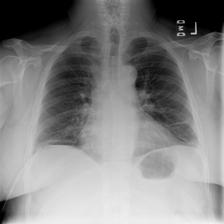

In [621]:
# print (image_list[image])
Image.open('test.jpg')

In [622]:
# cv2.imread('test.jpg').shape

In [623]:
img_tensor = preprocess(img_pil)
# img_tensor.shape

In [624]:
img_variable = Variable(img_tensor.unsqueeze(0).cuda())
img_variable.shape

torch.Size([1, 3, 224, 224])

In [625]:
logit = net(img_variable)
# logit

In [626]:
# download the imagenet category list
# classes = {int(key):value for (key, value)
#           in requests.get(LABELS_URL).json().items()}
classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis','Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia','Pneumothorax']

In [627]:
h_x = (logit).data.squeeze()
probs, idx = h_x.sort(0, True)

In [628]:
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.565 -> Atelectasis
0.116 -> Infiltration
0.060 -> Fibrosis
0.034 -> Pneumothorax
0.033 -> Pleural_Thickening


In [629]:
## Function to plot 2 images
def show_images(images, titles) :   
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(1, 2, n+1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)

In [630]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

True Label: Atelectasis
output CAM.jpg for the top1 prediction: Atelectasis


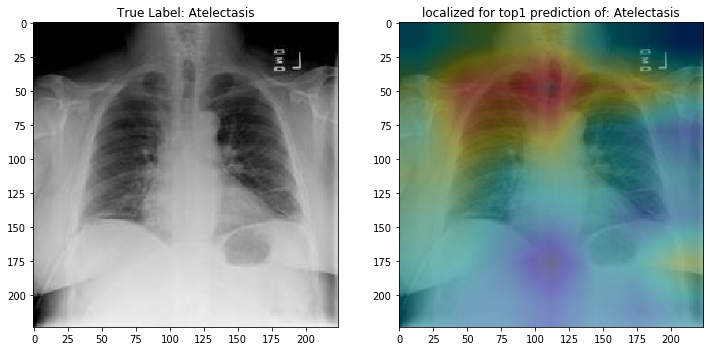

In [631]:
## Plots the original image if disease detected; along with the localization

img = cv2.imread('test.jpg')
if probs[0] > 0.5:
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    print('True Label: %s'%label_dict[image_list[image].split("/")[1]])
    print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
    cv2.imwrite('CAM.jpg', result)
    cam_img = mpimg.imread('CAM.jpg')
    images = [img, cam_img]
    titles = ['True Label: ' + label_dict[image_list[image].split("/")[1]],
              'localized for top1 prediction of: ' + classes[idx[0]]]
    show_images(images, titles)
else:
    print('True Label: %s'%label_dict[image_list[image].split("/")[1]])
    print(('output CAM.jpg for the top1 prediction: No Finding'))
    show_images([img]," ")
#     plt.imshow(img)